# Tutorial explaining the use of different emulators, from different archives

In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# our modules
from lace.archive import gadget_archive
from lace.archive import nyx_archive
from lace.emulator.nn_emulator import NNEmulator
from lace.emulator.gp_emulator import GPEmulator

## CREATE TRAINING AND TESTING ARCHIVE (Gadget)

In [3]:
# list of emulator parameters used with Gadget sims
emu_params=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']

In [4]:
archive = gadget_archive.GadgetArchive(postproc="Pedersen21")
training_data=archive.get_training_data(emu_params=emu_params)
len(training_data)

330

In [5]:
testing_data = archive.get_testing_data(sim_label='mpg_central')
len(testing_data)

11

In [6]:
kMpc = testing_data[0]['k_Mpc']
kMpc = kMpc[(kMpc>0) & (kMpc<4)]

## NEURAL NETWORK EMULATOR  

Some of the cells in this notebooks can be quite slow, so we only run them if thorough==True

In [7]:
thorough=False

#### To create an emulator object, we can call NNemulator (to create a neural network emulator) or GP emulator (to create a Gaussian process emulator). 

### Example 1: We can train a custom emulator... 

#### A. passing a custom archive:

In [8]:
emulator = NNEmulator(archive=archive, nepochs=10)

Selected custom emulator
Use custom archive provided by the user


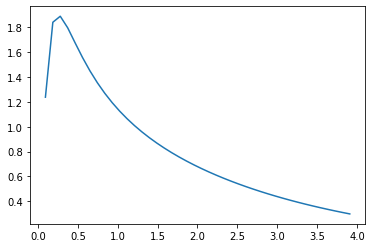

In [9]:
# test emulator by making simple plot
p1d = emulator.emulate_p1d_Mpc(testing_data[0],kMpc)
plt.plot(kMpc,p1d)

### or a training_set label

In [10]:
if thorough:
    emulator = NNEmulator(training_set='Cabayol23',nepochs=10)

#### If none or both are provided, the emulator fails. 

### Example 2: We can train a pre defined emulator... 

#### A. with a training_set label

In [11]:
if thorough:
    emulator = NNEmulator(training_set='Cabayol23', emulator_label='Cabayol23', nepochs=10)

#### B. with an archive

In [12]:
# currently we are passing a Pedersen21 archive and asking for Cabayol23 emulator (for emu settings)
emulator = NNEmulator(archive=archive,  emulator_label='Cabayol23', nepochs=10)

Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<4.5. The parameters passed to the emulator will be overwritten to match these ones
Use custom archive provided by the user


### Example 3: Load a pre-trained emulator, providing the path of the saved network parameters

In [13]:
if thorough:
    emulator = NNEmulator(training_set='Cabayol23',emulator_label='Cabayol23',
                      model_path='NNmodels/NNEmulator_LaCEHC.pt', train=False)

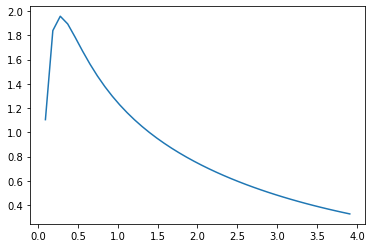

In [14]:
# test emulator by making simple plot
p1d = emulator.emulate_p1d_Mpc(testing_data[0],kMpc)
plt.plot(kMpc,p1d)

## GAUSSIAN PROCESS EMULATOR

## The Gaussian process emulator uses the following default parameters:

- paramList=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
- kmax_Mpc=10
- ndeg=4

### Example 1: Train custom emulator 

#### with a defined training_set

In [15]:
if thorough:
    emulator = GPEmulator(training_set='Pedersen21')

#### with a custom archive

In [16]:
emulator = GPEmulator(archive=archive)

Use custom archive provided by the user
Selected custom emulator


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.50 seconds


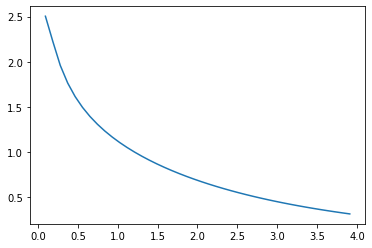

In [17]:
# test emulator by making simple plot
p1d = emulator.emulate_p1d_Mpc(testing_data[0],kMpc)
plt.plot(kMpc,p1d)

#### if both are provided, the emulator fails

### Example 2: Pre-defined GP emulators:

In [18]:
if thorough:
    emulator = GPEmulator(training_set='Pedersen21', emulator_label='Pedersen21')

In [19]:
if thorough:
    emulator = GPEmulator(training_set='Pedersen21', emulator_label='Pedersen23')

In [20]:
if thorough:
    emulator = GPEmulator(training_set='Pedersen21')

## LaCE-Nyx emulator (NN)

In [21]:
# emulators will use different emulator parameters depending on the archive
#gadget_emu_params = ['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
nyx_emu_params = ['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'lambda_P']

In [22]:
# you could specify here the path to the Nyx files, or set a NYX_PATH variable
#nyx_fname = '/data/desi/scratch/HydroData/Emulator/nyx_files/models.hdf5'
nyx_fname=None
archive = nyx_archive.NyxArchive(file_name=nyx_fname)

In [23]:
emulator = NNEmulator(archive=archive, nepochs=100,emu_params=nyx_emu_params)

Selected custom emulator
Use custom archive provided by the user


In [24]:
training_data = archive.get_training_data(emu_params=nyx_emu_params)
kMpc = training_data[0]['k_Mpc']
kMpc = kMpc[(kMpc>0) & (kMpc<4)]

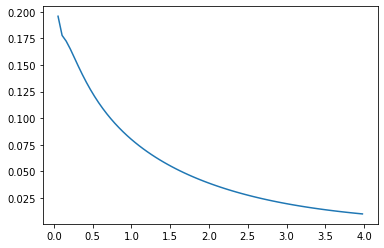

In [25]:
# test emulator by making simple plot
testing_data = archive.get_testing_data(sim_label='nyx_0',emu_params=nyx_emu_params)
p1d = emulator.emulate_p1d_Mpc(testing_data[0],kMpc)
plt.plot(kMpc,p1d)

In [26]:
emulator = NNEmulator(archive=archive, emulator_label='Cabayol23_Nyx')

Select emulator in Cabayol23_Nyx
Neural network emulating the optimal P1D of Nyx simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<4.5. The parameters passed to the emulator will be overwritten to match these ones
Use custom archive provided by the user


In [27]:
if thorough:
    emulator = NNEmulator(training_set='Nyx23',emu_params=nyx_emu_params,nepochs=100)